<a href="https://colab.research.google.com/github/raymundojavajr/Deep_Learning_Pytorch/blob/main/MNIST_CNN_Training_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification with PyTorch: Building and Evaluating a CNN

In [1]:
# PyTorch core and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# DataLoader for batch processing
from torch.utils.data import DataLoader

# torchvision for datasets and transformations
from torchvision import datasets, transforms

# Utility to visualize image grids
from torchvision.utils import make_grid

# NumPy for numerical operations, Pandas for data analysis
import numpy as np
import pandas as pd

# Scikit-learn for confusion matrix
from sklearn.metrics import confusion_matrix

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Convert MNIST images to PyTorch tensors and normalize to [0.0, 1.0]
transform = transforms.ToTensor()


In [3]:
# Load and transform MNIST training data
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 55728080.10it/s]


Extracting cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1773608.60it/s]

Extracting cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to cnn_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14826810.01it/s]


Extracting cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4468808.06it/s]

Extracting cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to cnn_data/MNIST/raw



In [4]:
# Load and transform MNIST test data
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Data loaders with small batch size for training and testing
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define CNN layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Grab the first MNIST image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
# Check the shape of the first MNIST image
X_train.shape

torch.Size([1, 28, 28])

In [11]:
# Reshape X_train for the CNN input
x = X_train.view(1, 1, 28, 28)

In [12]:
# Apply first convolution with ReLU activation
x = F.relu(conv1(x))

In [13]:
# Shape after first convolution: 1 image, 6 filters, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# Apply max pooling with 2x2 kernel and stride 2
x = F.max_pool2d(x, 2, 2)

In [15]:
# Shape after max pooling: 1 image, 6 filters, 13x13
x.shape  # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# Apply second convolution with ReLU activation
x = F.relu(conv2(x))

In [17]:
# Shape after second convolution
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
# Apply second max pooling and check shape
x = F.max_pool2d(x, 2, 2)
x.shape  # Shape after second max pooling

torch.Size([1, 16, 5, 5])

### Model Class

In [19]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)

        # Fully connected layers
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        # Apply convolutional layers with ReLU and max pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # Flatten and apply fully connected layers
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


In [20]:
# Create an instance of the CNN model
torch.manual_seed(41)  # Set manual seed for reproducibility
model = ConvolutionalNeuralNetwork()
model  # Display the model architecture

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [30]:
import time
import torch

# Start timer
start_time = time.time()

# Hyperparameters and tracking
epochs = 5
train_losses = []
test_losses = []
train_correct_counts = []
test_correct_counts = []

# Training loop
for epoch in range(epochs):
    train_correct = 0
    test_correct = 0

    # Training phase
    model.train()
    for batch_idx, (X_train, y_train) in enumerate(train_loader, start=1):

        # Forward pass and loss
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Calculate correct predictions
        predicted_labels = torch.max(y_pred.data, 1)[1]
        train_correct += (predicted_labels == y_train).sum().item()

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 600 batches
        if batch_idx % 600 == 0:
            print(f'Epoch: {epoch+1}/{epochs}  Batch: {batch_idx}  Loss: {loss.item():.4f}')

    # Track training loss and correct counts after the epoch
    train_losses.append(loss.item())
    train_correct_counts.append(train_correct)

    # Testing phase
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:

            # Forward pass for test data
            y_val = model(X_test)
            predicted_labels = torch.max(y_val.data, 1)[1]
            test_correct += (predicted_labels == y_test).sum().item()

        # Track test loss and correct counts after the epoch
        loss = criterion(y_val, y_test)
        test_losses.append(loss.item())
        test_correct_counts.append(test_correct)

# Total time taken
total_time = time.time() - start_time
print(f'Total Time: {total_time / 60:.2f} minutes')

Epoch: 1/5  Batch: 600  Loss: 0.0004
Epoch: 1/5  Batch: 1200  Loss: 0.0002
Epoch: 1/5  Batch: 1800  Loss: 0.0005
Epoch: 1/5  Batch: 2400  Loss: 0.0274
Epoch: 1/5  Batch: 3000  Loss: 0.0003
Epoch: 1/5  Batch: 3600  Loss: 0.0001
Epoch: 1/5  Batch: 4200  Loss: 0.0004
Epoch: 1/5  Batch: 4800  Loss: 0.0000
Epoch: 1/5  Batch: 5400  Loss: 0.0005
Epoch: 1/5  Batch: 6000  Loss: 0.0002
Epoch: 2/5  Batch: 600  Loss: 0.0001
Epoch: 2/5  Batch: 1200  Loss: 0.0003
Epoch: 2/5  Batch: 1800  Loss: 0.0003
Epoch: 2/5  Batch: 2400  Loss: 0.0001
Epoch: 2/5  Batch: 3000  Loss: 0.0002
Epoch: 2/5  Batch: 3600  Loss: 0.1239
Epoch: 2/5  Batch: 4200  Loss: 0.0002
Epoch: 2/5  Batch: 4800  Loss: 0.0003
Epoch: 2/5  Batch: 5400  Loss: 0.0819
Epoch: 2/5  Batch: 6000  Loss: 1.2692
Epoch: 3/5  Batch: 600  Loss: 0.0011
Epoch: 3/5  Batch: 1200  Loss: 0.0001
Epoch: 3/5  Batch: 1800  Loss: 0.1029
Epoch: 3/5  Batch: 2400  Loss: 0.0001
Epoch: 3/5  Batch: 3000  Loss: 0.0001
Epoch: 3/5  Batch: 3600  Loss: 0.0012
Epoch: 3/5  Bat

### Plotting

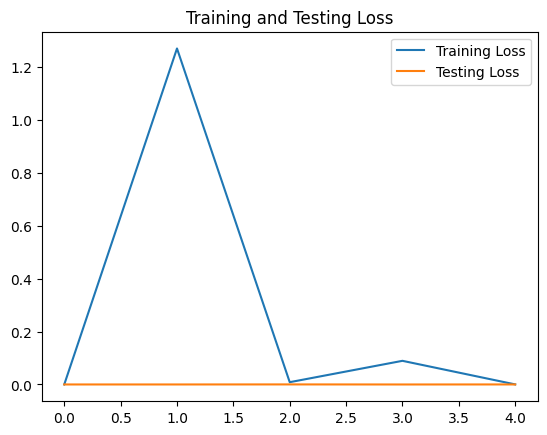

In [31]:
# Plot training and testing losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()

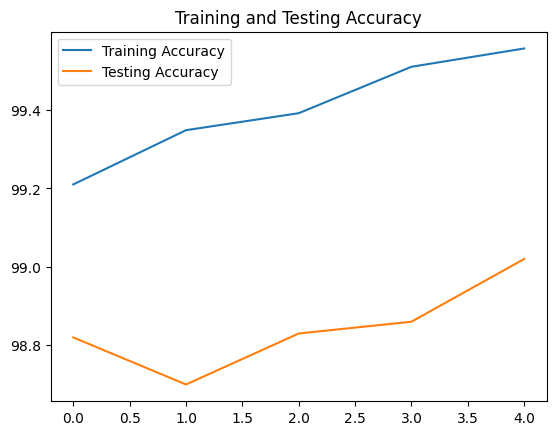

In [32]:
# Plot training and testing accuracy
plt.plot([t/600 for t in train_correct_counts], label='Training Accuracy')
plt.plot([t/100 for t in test_correct_counts], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

In [34]:
# Load entire test dataset in one batch
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [35]:
# Calculate test accuracy over the entire test dataset
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted_labels = torch.max(y_val.data, 1)[1]
        correct += (predicted_labels == y_test).sum().item()
    print(f'Test Accuracy: {correct / len(test_data):.4f}')

Test Accuracy: 0.9902


In [36]:
# Reshape the 1978th test image to 28x28
test_data[1978][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

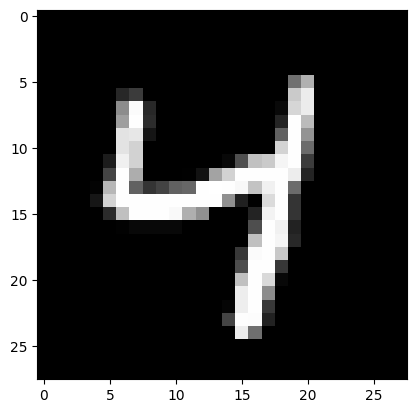

In [37]:
# Display the 1978th test image
plt.imshow(test_data[1978][0].reshape(28, 28), cmap='gray')

In [38]:
# Evaluate the model on a single test image
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1, 1, 28, 28))

In [39]:
# Get the predicted class label
new_prediction.argmax()

tensor(9)

# END